/tmp/ipykernel_24901/4237335710.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = longpr.groupby(['Intervention', 'label'])[metric].mean()
/tmp/ipykernel_24901/4237335710.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = longpr.groupby(['Intervention', 'label'])[metric].median()


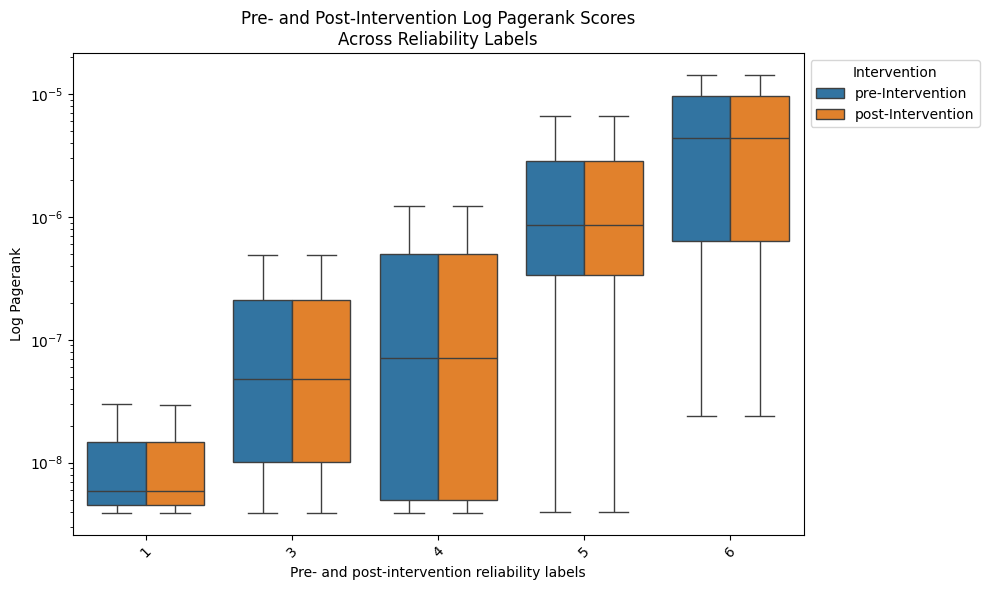

In [17]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

metric = "pagerank_centrality"
domain_labels = pd.read_csv('../../data/attributes.csv')[['url', 'label']]
cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]
# Read pre and post rankings data
def reverse_url(url):
    components = str(url).split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

pre_rankings = pd.read_csv('output/ranks/exp-baseline.label_only.out', sep='\t', names=cc_rank_cols)
post_rankings = pd.read_csv('output/ranks/exp-ls-ppr-down.label_only.out', sep='\t', names=cc_rank_cols)
# post_rankings = pd.read_csv('output/ranks/exp-ls-ppr-down.label_only.out', sep='\t', names=cc_rank_cols)
# post_rankings = pd.read_csv('output/ranks/exp-rel-ppr.label_only.out', sep='\t', names=cc_rank_cols)
pre_rankings['url'] = pre_rankings['url'].apply(reverse_url)
post_rankings['url'] = post_rankings['url'].apply(reverse_url)


# Filter columns
pre_rankings = pre_rankings.iloc[:, :-1]  # Drop last column
post_rankings = post_rankings.iloc[:, :-1]  # Drop last column

# Merge with domain labels data
pre_rankings_filtered = pre_rankings.merge(domain_labels, on='url', how='inner')
post_rankings_filtered = post_rankings.merge(domain_labels, on='url', how='inner')

beforepr = pre_rankings_filtered[['url', 'label', metric]].assign(Intervention=0)
afterpr = post_rankings_filtered[['url', 'label', metric]].assign(Intervention=1)

# Combine dataframes
longpr = pd.concat([beforepr, afterpr], ignore_index=True)
longpr['label'] = pd.Categorical(longpr['label'])

# Group means/medians
group_means = longpr.groupby(['Intervention', 'label'])[metric].mean()
group_medians = longpr.groupby(['Intervention', 'label'])[metric].median()

# Plot
# plt.figure(figsize=(10, 6))
# longpr.boxplot(column=metric, by=['Intervention', 'label'], grid=False, rot=45)
# plt.title('Pre- and Post-Intervention Log Pagerank Scores\nAcross Reliability Labels')
# plt.xlabel('Pre- and post-intervention reliability labels')
# plt.ylabel('Log Pagerank')
# plt.legend(['pre-Intervention', 'post-Intervention'], loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.show()

longpr['Intervention_Group'] = longpr['Intervention'].apply(lambda x: 'pre-Intervention' if x == 0 else 'post-Intervention')
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y=metric, hue='Intervention_Group', data=longpr, showfliers=False)
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Pre- and Post-Intervention Log Pagerank Scores\nAcross Reliability Labels')
plt.xlabel('Pre- and post-intervention reliability labels')
plt.ylabel('Log Pagerank')
plt.legend(title='Intervention', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Statistical tests
# T-test
t_stat, p_value = ttest_ind(longpr[longpr['Intervention'] == 0][metric],
                             longpr[longpr['Intervention'] == 1][metric])

# ANOVA
model = ols('pagerank_centrality ~ label', data=beforepr).fit()
anova_table = anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
label,1.0,1.094386e-08,1.094386e-08,17.188699,0.000035
Residual,3903.0,2.484998e-06,6.366893e-10,NaN,NaN


In [17]:
from scipy.stats import mannwhitneyu, kruskal
import numpy as np

# Example data (replace with your actual data)
pre_intervention_data = pre_rankings_filtered[[metric]]
post_intervention_data = post_rankings_filtered[[metric]]
assert(all(post_rankings_filtered['url'] == pre_rankings_filtered['url']))
group_labels = pre_rankings_filtered['label']

# Perform Mann-Whitney U test for each group
for label in np.unique(group_labels):
    group_pre = pre_intervention_data[group_labels == label]
    group_post = post_intervention_data[group_labels == label]
    _, p_value = mannwhitneyu(group_pre, group_post)
    print(f"Mann-Whitney U test p-value for group {label}: {p_value}")

# Perform Kruskal-Wallis H test
_, p_value = kruskal(pre_intervention_data, post_intervention_data)
print(f"Kruskal-Wallis H test p-value: {p_value}")


Mann-Whitney U test p-value for group 1: [6.40112782e-15]
Mann-Whitney U test p-value for group 3: [3.87391612e-22]
Mann-Whitney U test p-value for group 4: [8.50407355e-08]
Mann-Whitney U test p-value for group 5: [0.]
Mann-Whitney U test p-value for group 6: [3.22783701e-07]
Kruskal-Wallis H test p-value: [1.14946585e-260]
